In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Premièrement, on importe la dataset

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"


In [ ]:
%cd /content/drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


In [ ]:
pwd

'/content/drive/MyDrive/kaggle'

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 98% 660M/675M [00:05<00:00, 168MB/s]
100% 675M/675M [00:05<00:00, 128MB/s]


In [ ]:
!ls

cell-images-for-detecting-malaria.zip  kaggle.json


In [ ]:
!unzip \*.zip  && rm *.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_22

Nous avons deux dossiers qui contiennent des images de cellules, infectées et saines. Nous pouvons obtenir plus de détails sur le nombre total d'images en entrant : 

In [ ]:
import os
import glob

base_dir = os.path.join('./cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13779, 13779)

Il semble que nous ayons un ensemble de données équilibré avec 13 779 images de cellules paludiques et 13 779 images de cellules non paludiques (non infectées). Construisons un cadre de 
données à partir de ces données, que nous utiliserons lorsque nous commencerons à construire nos ensembles de données. 
 
 

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,./cell_images/Parasitized/C130P91ThinF_IMG_201...,malaria
1,./cell_images/Parasitized/C188P149ThinF_IMG_20...,malaria
2,./cell_images/Uninfected/C173P134NThinF_IMG_20...,healthy
3,./cell_images/Uninfected/C78P39ThinF_IMG_20150...,healthy
4,./cell_images/Uninfected/C107P68ThinF_IMG_2015...,healthy


**Construire et explorer des ensembles de données d'image**

Pour construire des modèles d'apprentissage en profondeur, nous avons besoin de données sur la formation, mais nous devons également tester les performances du modèle sur des données invisibles. Nous utiliserons une répartition 60:10:30 pour les ensembles de données de formation, de validation et de test, respectivement. Nous utiliserons les ensembles de données de formation et de validation pendant la formation et nous vérifierons la performance du modèle sur l'ensemble de données de test. 

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values,
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels,
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(17361,) (1929,) (8268,)
Train: Counter({'healthy': 8734, 'malaria': 8627}) 
Val: Counter({'healthy': 970, 'malaria': 959}) 
Test: Counter({'malaria': 4193, 'healthy': 4075})


Les images ne seront pas de dimensions égales car les frottis sanguins et les images cellulaires varient selon l'homme, la méthode de test et l'orientation de la photo. Récapitulons quelques statistiques de notre ensemble de données de formation pour déterminer les dimensions optimales des images 



**Obtenir des statistiques sommaires sur la dimension de l'image**

In [ ]:
import cv2
from concurrent import futures
import threading

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
 
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel,
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0))
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_6: working on img num: 5000
ThreadPoolExecutor-0_8: working on img num: 10000
ThreadPoolExecutor-0_6: working on img num: 15000
ThreadPoolExecutor-0_1: working on img num: 17360
Min Dimensions: [46 49  3]
Avg Dimensions: [132.89856575 132.50751685   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [382 394   3]


Nous appliquons un traitement parallèle pour accélérer les opérations de lecture d'image et, sur la base des statistiques récapitulatives, nous redimensionnerons chaque image à 125x125 pixels. Chargeons toutes nos images et redimensionnons-les à ces dimensions fixes.

**Charger et redimensionner les images**

In [ ]:
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS,
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel,
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel,
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel,
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_5: working on img num: 5000
ThreadPoolExecutor-1_5: working on img num: 10000
ThreadPoolExecutor-1_1: working on img num: 15000
ThreadPoolExecutor-1_7: working on img num: 17360

Loading Validation Images:
ThreadPoolExecutor-1_3: working on img num: 0
ThreadPoolExecutor-1_3: working on img num: 1928

Loading Test Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_9: working on img num: 5000
ThreadPoolExecutor-1_5: working on img num: 8267


((17361, 125, 125, 3), (1929, 125, 125, 3), (8268, 125, 125, 3))

Nous exploitons à nouveau le traitement parallèle pour accélérer les calculs relatifs au chargement et au redimensionnement des images. Enfin, nous obtenons nos tenseurs d'image des dimensions souhaitées, comme illustré dans la sortie précédente. Nous pouvons maintenant afficher des exemples d'images de cellules pour avoir une idée de l'apparence de nos données 

**Voir des exemples d'images de cellules**

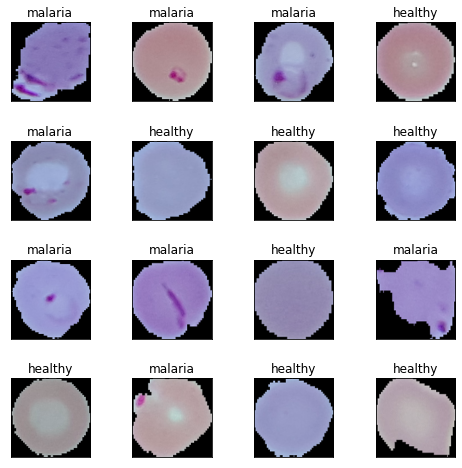

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0
for i in range(16):
    n += 1
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

Sur la base de ces exemples d'images, nous pouvons voir des différences subtiles entre le paludisme et les images de cellules saines. Nous ferons en sorte que nos modèles d'apprentissage en profondeur essaient d'apprendre ces modèles pendant la formation des modèles. 
 
Avant de pouvoir commencer à entraîner nos modèles, nous devons configurer certains paramètres de configuration de base. 

**Paramètres de configuration, Images à l'échelle et classes d'encodage des étiquettes**


In [ ]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['malaria' 'malaria' 'malaria' 'healthy' 'healthy' 'malaria'] [1 1 1 0 0 1]


In [ ]:
import tensorflow as tf

tf.random.set_seed(42)
tf.__version__

'2.4.1'

Nous fixons les dimensions de nos images, la taille des lots et les époques et codons nos étiquettes de classe catégorielle. La version alpha de TensorFlow 2.4 est sortie en 2020 et cet exercice est l'excuse parfaite pour l'essayer. 

**Deep learning model training**

Formation aux modèles d'apprentissage profond Dans la phase de formation du modèle, nous créerons trois modèles d'apprentissage en profondeur, les formerons avec nos données d'entraînement et comparerons leurs performances 
à l'aide des données de validation. Nous enregistrerons ensuite ces modèles et les utiliserons plus tard dans la phase d'évaluation du modèle. 

**Modèle 1 : CNN from Scratch**

Notre premier modèle de détection du paludisme va construire et former un CNN de base à partir de zéro. Tout d'abord, définissons notre architecture de modèle. 

**Construire une architecture modèle** 

In [ ]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3),
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3),
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0     

Basé sur l'architecture de ce code, notre modèle CNN comporte trois couches de convolution et de regroupement, suivies de deux couches denses et d'abandons pour la régularisation. Entraînons notre modèle. 

**Modèle de train**

In [ ]:
import datetime

logdir = os.path.join('/home/dipanzan_sarkar/projects/tensorboard_logs',
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(val_imgs_scaled, val_labels_enc),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/25
272/272 [==============================] - 19s 41ms/step - loss: 0.5782 - accuracy: 0.6774 - val_loss: 0.2164 - val_accuracy: 0.9217
Epoch 2/25
272/272 [==============================] - 10s 35ms/step - loss: 0.1831 - accuracy: 0.9412 - val_loss: 0.1494 - val_accuracy: 0.9580
Epoch 3/25
272/272 [==============================] - 10s 36ms/step - loss: 0.1455 - accuracy: 0.9545 - val_loss: 0.1366 - val_accuracy: 0.9611
Epoch 4/25
272/272 [==============================] - 10s 36ms/step - loss: 0.1447 - accuracy: 0.9491 - val_loss: 0.1354 - val_accuracy: 0.9570
Epoch 5/25
272/272 [==============================] - 10s 36ms/step - loss: 0.1153 - accuracy: 0.9626 - val_loss: 0.1286 - val_accuracy: 0.9585
Epoch 6/25
272/272 [==============================] - 10s 36ms/step - loss: 0.1009 - accuracy: 0.9655 - val_loss: 0.1395 - val_accuracy: 0.9622
Epoch 7/25
272/272 [==============================] - 10s 36ms/step - loss: 0.0799 - accuracy: 0.9722 - val_loss: 0.1458 - val_accuracy:

Nous obtenons une précision de validation de 95,6 %, ce qui est plutôt bon, bien que notre modèle semble légèrement surdimensionné (si l'on se base sur la précision de notre formation, qui est de 99,9 %). Nous pouvons obtenir une perspective claire à ce sujet en traçant les courbes de précision et de perte de la formation et de la validation. 

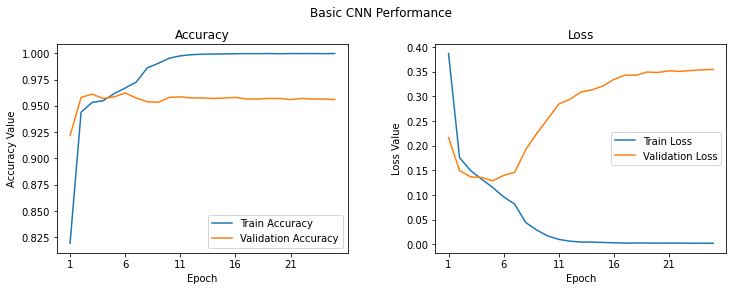

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Nous pouvons voir après la cinquième époque que les choses ne semblent pas s'améliorer beaucoup dans l'ensemble. Sauvegardons ce modèle pour une évaluation future.

**Modèle de sauvegarde**

In [ ]:
model.save('basic_cnn.h5')

**Deep transfer learning** 


**Modèle 2 : Modèle préformé en tant qu'extracteur de caractéristiques** 

Pour construire ce modèle, nous utiliserons TensorFlow pour charger le modèle VGG-19 et geler les blocs de convolution afin de pouvoir les utiliser comme extracteur de caractéristiques d'image. Nous ajouterons nos propres couches denses à la fin pour effectuer la tâche de classification. 

**Construire une architecture modèle**

In [ ]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
vgg.trainable = False
# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
____________________________________________________________

In [ ]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 6


Il est évident que notre modèle comporte de nombreuses couches et nous utiliserons les couches gelées du modèle VGG-19 uniquement comme extracteurs de caractéristiques. Vous pouvez utiliser le code suivant pour vérifier combien de couches de notre modèle sont effectivement entraînables et combien de couches totales sont présentes dans notre réseau. 

**Modèle de train**

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/25
272/272 [==============================] - 34s 118ms/step - loss: 0.4907 - accuracy: 0.7506 - val_loss: 0.3141 - val_accuracy: 0.8554
Epoch 2/25
272/272 [==============================] - 30s 111ms/step - loss: 0.3025 - accuracy: 0.8701 - val_loss: 0.2618 - val_accuracy: 0.8854
Epoch 3/25
272/272 [==============================] - 30s 111ms/step - loss: 0.2686 - accuracy: 0.8893 - val_loss: 0.2271 - val_accuracy: 0.9057
Epoch 4/25
272/272 [==============================] - 31s 112ms/step - loss: 0.2486 - accuracy: 0.8989 - val_loss: 0.2209 - val_accuracy: 0.9062
Epoch 5/25
272/272 [==============================] - 30s 111ms/step - loss: 0.2269 - accuracy: 0.9105 - val_loss: 0.1968 - val_accuracy: 0.9217
Epoch 6/25
272/272 [==============================] - 30s 111ms/step - loss: 0.2176 - accuracy: 0.9134 - val_loss: 0.1879 - val_accuracy: 0.9238
Epoch 7/25
272/272 [==============================] - 30s 112ms/step - loss: 0.2042 - accuracy: 0.9197 - val_loss: 0.1902 - val_ac

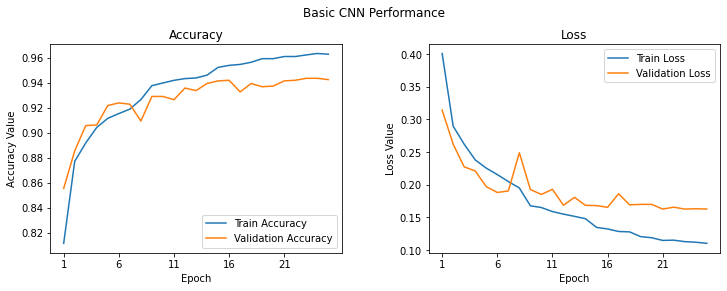

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Nous allons maintenant entraîner notre modèle en utilisant des configurations et des rappels similaires à ceux que nous avons utilisés dans notre modèle précédent. 

**Modèle de sauvegarde**

In [ ]:
model.save('vgg_frozen.h5')

**Construire des amplificateurs d'image**

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Labels: ['malaria', 'malaria', 'malaria', 'malaria', 'malaria']


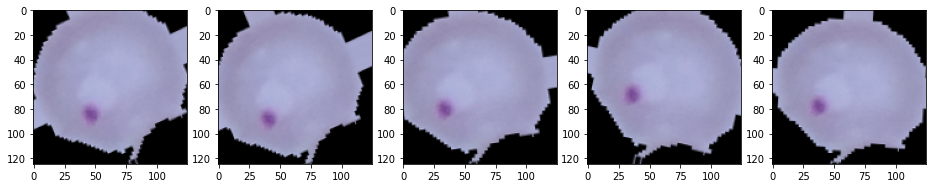

In [ ]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

Vous pouvez voir clairement les légères variations de nos images dans la sortie précédente. Nous allons maintenant construire notre modèle d'apprentissage profond, en nous assurant que les deux derniers blocs du modèle VGG-19 sont entraînables. 

**Apprentissage par transfert**

**Modèle 3 : CNN préformé avec augmentation de l'image**

**Construire une architecture modèle**

In [ ]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
# Freeze the layers
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 16


Nous réduisons le taux d'apprentissage dans notre modèle car nous ne voulons pas faire de trop grandes mises à jour des couches préformées lors de la mise au point. Le processus d'apprentissage du modèle sera légèrement différent puisque nous utilisons des générateurs de données, nous utiliserons donc la fonction fit_generator(...). 

In [ ]:
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

**Modèle de train**

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
271/271 [==============================] - 77s 277ms/step - loss: 0.3583 - accuracy: 0.8277 - val_loss: 0.1250 - val_accuracy: 0.9563
Epoch 2/25
271/271 [==============================] - 75s 276ms/step - loss: 0.1493 - accuracy: 0.9511 - val_loss: 0.1334 - val_accuracy: 0.9573
Epoch 3/25
271/271 [==============================] - 75s 277ms/step - loss: 0.1349 - accuracy: 0.9525 - val_loss: 0.1079 - val_accuracy: 0.9635
Epoch 4/25
271/271 [==============================] - 75s 276ms/step - loss: 0.1162 - accuracy: 0.9600 - val_loss: 0.1046 - val_accuracy: 0.9641
Epoch 5/25
271/271 [==============================] - 75s 276ms/step - loss: 0.1228 - accuracy: 0.9570 - val_loss: 0.1030 - val_accuracy: 0.9667
Epoch 6/25
271/271 [==============================] - 75s 275ms/step - loss: 0.1096 - accuracy: 0.9646 - val_loss: 0.0985 - val_accuracy: 0.9677
Epoch 7/25
271/271 [==============================] - 75s 275ms/step - loss: 0.1095 - accuracy: 0.9610 - val_loss: 0.1020 - val_ac

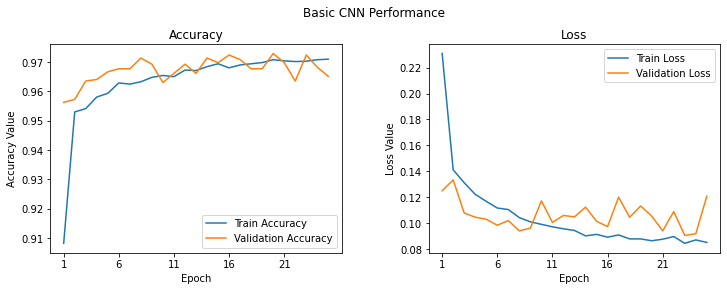

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Cela semble être notre meilleur modèle à ce jour. Il nous donne une précision de validation de près de 96,5 % et, d'après la précision de la formation, il ne semble pas que notre modèle soit aussi surdimensionné que notre premier modèle. Cela peut être vérifié à l'aide des courbes d'apprentissage suivantes.

**Modèle de sauvegarde**

In [ ]:
model.save('vgg_finetuned.h5')

**Modèle d'évaluation des performance**

**Évaluation des performances du modèle d'apprentissage approfondi**

Nous allons évaluer les trois modèles que nous avons construits pendant la phase de formation en faisant des prévisions avec eux sur les données de notre jeu de données de test - car une simple validation ne suffit pas ! Nous avons également construit un module utilitaire très pratique appelé model_evaluation_utils, que nous pouvons utiliser pour évaluer les performances de nos modèles d'apprentissage approfondi avec des mesures de classification pertinentes. La première étape consiste à mettre à l'échelle nos données de test. 


In [ ]:
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((8268, 125, 125, 3), (8268,))

L'étape suivante consiste à charger nos modèles d'apprentissage profond sauvegardés et à faire des prédictions sur les données de test. 

Modèles d'apprentissage en profondeur 
sauvegardés et faire des prédictions sur les données d'essai 
 
 

In [ ]:
basic_cnn = tf.keras.models.load_model('./basic_cnn.h5')
vgg_frz = tf.keras.models.load_model('./vgg_frozen.h5')
vgg_ft = tf.keras.models.load_model('./vgg_finetuned.h5')

In [ ]:
basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=512)
vgg_frz_preds = vgg_frz.predict(test_imgs_scaled, batch_size=512)
vgg_ft_preds = vgg_ft.predict(test_imgs_scaled, batch_size=512)

basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in basic_cnn_preds.ravel()])
vgg_frz_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_frz_preds.ravel()])
vgg_ft_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_ft_preds.ravel()])

L'étape finale consiste à exploiter notre module model_evaluation_utils et à vérifier les performances de chaque modèle à l'aide de mesures de classification pertinentes.

In [ ]:
import model_evaluation_utils as meu
import pandas as pd

basic_cnn_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=basic_cnn_pred_labels)
vgg_frz_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=vgg_frz_pred_labels)
vgg_ft_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=vgg_ft_pred_labels)

pd.DataFrame([basic_cnn_metrics, vgg_frz_metrics, vgg_ft_metrics], 
             index=['Basic CNN', 'VGG-19 Frozen', 'VGG-19 Fine-tuned'])

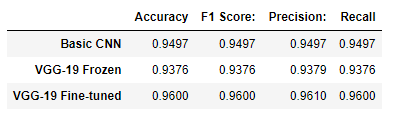




Il semble que notre troisième modèle soit le plus performant sur l'ensemble des données de test, donnant une précision du modèle et un score F1 de 96%, ce qui est assez bon et tout à fait comparable aux modèles plus complexes mentionnés dans le document de recherche et les articles que nous avons mentionnés précédemment. 
Conclusion 